In [2]:
!pip install pyserial

You should consider upgrading via the 'C:\Users\humph\Anaconda3\python.exe -m pip install --upgrade pip' command.


Going for process, round 1
Printing the first 5 elements

[{'uniqueDeviceId': 'Infinix X559_045970be-e4d4-4486-9a3b-2954605fbf5b', 'lat': -0.3991476, 'long': 36.9627043, 'alt': 1763.2000732421875, 'accuracyGPS': 20, 'directionEastWest': 'E', 'directionNorthSouth': 'S', 'accuracy': None, 'accX': 0, 'accY': 0, 'accZ': 0, 'rssi': 0, 'date': '2022-01-31T21:00:00', 'time': '16:58:18', 'id': 727}, {'uniqueDeviceId': 'Infinix X559_e8f64b55-3aab-4fc4-8ada-4c96efc8b683', 'lat': -0.3991476, 'long': 36.9627043, 'alt': 1763.2000732421875, 'accuracyGPS': 20, 'directionEastWest': 'E', 'directionNorthSouth': 'S', 'accuracy': None, 'accX': 0, 'accY': 0, 'accZ': 0, 'rssi': 0, 'date': '2022-01-31T21:00:00', 'time': '16:58:17', 'id': 726}, {'uniqueDeviceId': 'Infinix X559_65e50440-8243-4161-877a-9e95407766f6', 'lat': -0.399143, 'long': 36.9627101, 'alt': 1763.2000732421875, 'accuracyGPS': 20, 'directionEastWest': 'E', 'directionNorthSouth': 'S', 'accuracy': None, 'accX': 0, 'accY': 0, 'accZ': 0, 'rssi': 

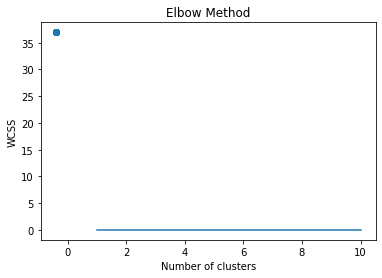

Determining the centroid for each clustern



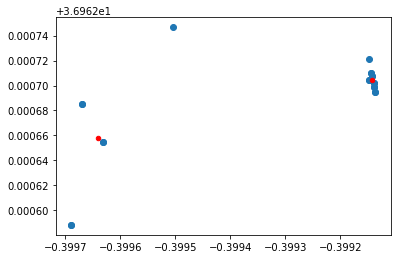

Calculating the bearing of the centroid of the biggest cluster

The Bearing of the Centroid of the biggest Cluster is 11.529975303027594
Sending the Bearing of the Biggest Cluster Centroid to Arduino



SerialException: could not open port 'COM9': PermissionError(13, 'Access is denied.', None, 5)

In [2]:
import requests
import json
import random
import numpy as np
import pandas as pd
import math
import time
import serial

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
from numpy import arctan2,random,sin,cos,degrees

url = 'http://odapapi.defrilab.com/api/Odap/recentMessages'
count=1

while(True):
    print('Going for process, round {}'.format(count))
    response = requests.get(url)
    data = response.json()
    print('Printing the first 5 elements\n')
    print(data[:5])
    loc_compact  = []
    for loc in data:
        loc_compact.append([loc['lat'],loc['long']])
    loc_compact = np.array(loc_compact)
    print('Ploting Scatter Plot\n')
    plt.scatter(loc_compact[:,0], loc_compact[:,1])
    wcss = []
    print('Determining the optimul number of clusters using the elbow method\n')
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=len(loc_compact), n_init=10, random_state=0)
        kmeans.fit(loc_compact)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()  
    print('Determining the centroid for each clustern\n')
    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=len(loc_compact), n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(loc_compact)
    plt.scatter(loc_compact[:,0], loc_compact[:,1])
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=len(loc_compact), c='red')
    plt.show()
    centroids = kmeans.cluster_centers_
    labels =list(kmeans.labels_)
    classes = list(set(labels))
    unique = Counter(labels)
    bigger_cluster = max(unique, key=unique.get)
    centroids = centroids[bigger_cluster]
    lat = centroids[0]
    long = centroids[1]
    print('Calculating the bearing of the centroid of the biggest cluster\n')
    a = {'lat': -0.399754, 'long': 36.96256867}
    b = {'lat': lat, 'long': long}
    dL = b['long'] - a['long']
    X = cos(b['lat'])* sin(dL)
    Y = cos(a['lat'])*sin(b['lat']) - sin(a['lat'])*cos(b['lat'])* cos(dL)
    bearing_rad = arctan2(X,Y)
    bearing_degrees = bearing_rad * (180/math.pi)
    print('The Bearing of the Centroid of the biggest Cluster is {}'.format(bearing_degrees))
    print('Sending the Bearing of the Biggest Cluster Centroid to Arduino\n')
    arduino = serial.Serial(port='COM9', baudrate=115200, timeout=.1)
    arduino.write(bytes(bearing_degrees, 'utf-8'))    
    print('Data sent to Arduino, waiting for response\n')
    time.sleep(0.05)
    response = arduino.readline()
    if(response=='ok'):
        print('Arduino just responded with Ok, data transmission was successful!\n')
        print('Process round {} completed successfully.'.format(count))
    else:
        print('Arduino is not responding for now, we wil try re-establish connection the next round, hope She will respond then\n')
    count +=1
    print('Going into sleep for 6 seconds before redoing the whole process\n')
    time.sleep(15)